## What is the most optimal skill to learn for Data Analysts?

### Methodology

1. Group skills to determine median salary and likelihood of being in job posting
2. Visualise median salary v. percent skill demand
3. Determine if certain technologies are more prevalent

In [1]:
# Importing libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt


# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

Found cached dataset csv (/Users/luciac/.cache/huggingface/datasets/lukebarousse___csv/lukebarousse--data_jobs-20095235c13fb98d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# Data Cleanup

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [ ]:
# Filtering df to Data Analyst roles in the US

df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()
df_DA_US

In [6]:
## Dropping NaN values and extracting skills from list

df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(10)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel
180,90250.0,powerpoint
410,133285.0,sql
410,133285.0,word
410,133285.0,excel
410,133285.0,visio


In [ ]:
# Grouping by skills to look at median salary and counts

df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})



In [13]:
DA_job_count = len(df_DA_US) # Getting the number of job postings to get percentages

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count *100

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.0,57.655172
excel,1808,84392.0,41.563218
python,1431,97500.0,32.896552
tableau,1364,92875.0,31.356322
sas,926,90000.0,21.287356
...,...,...,...
couchbase,1,160515.0,0.022989
chainer,1,100000.0,0.022989
chef,1,85000.0,0.022989


In [17]:
# Setting a limit of 5% to filter data (i.e. skill has to be in at least 5% of job postings to be included in plot)

skill_percent = 5

# Filtering skills
df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_percent]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


In [ ]:
# Grouping skills by technology
df_technology = df['job_type_skills'].copy()

# Remove duplicates
df_technology = df_technology.drop_duplicates()

# Remove NaN values
df_technology = df_technology.dropna()

df_technology

1         {'analyst_tools': ['power bi', 'tableau'], 'pr...
2         {'analyst_tools': ['dax'], 'cloud': ['azure'],...
3         {'cloud': ['aws'], 'libraries': ['tensorflow',...
4         {'cloud': ['oracle', 'aws'], 'other': ['ansibl...
5         {'cloud': ['gcp'], 'programming': ['python', '...
                                ...                        
785697    {'analyst_tools': ['power bi', 'tableau', 'wor...
785721    {'analyst_tools': ['looker', 'tableau', 'splun...
785725    {'cloud': ['bigquery'], 'libraries': ['gdpr'],...
785735    {'cloud': ['bigquery', 'aws'], 'libraries': ['...
785736    {'os': ['linux', 'unix'], 'other': ['kubernete...
Name: job_type_skills, Length: 177562, dtype: object

In [ ]:
# Create a new dictionary from the dictionaries in each cell

technology_dict = {}

for row in df_technology:
    row_dict = ast.literal_eval(row) # converting string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict: # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:
            technology_dict[key] = value # if key does not exist in technology_dic, add key and value

for key, value in technology_dict.items():
    technology_dict[key] = list(set(value)) # using set to remove duplicate values in dictionaries

technology_dict

In [35]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,nuix
0,analyst_tools,word
0,analyst_tools,tableau
0,analyst_tools,looker
0,analyst_tools,sharepoint
...,...,...
9,sync,mattermost
9,sync,unify
9,sync,zoom
9,sync,slack


In [42]:
df_plot = df_DA_skills_high_demand.merge(df_technology, left_on='job_skills', right_on='skills')
df_plot

,skill_count,median_salary,skill_percent,technology,skills
0,2508,91000.00,57.655172,programming,sql
1,1808,84392.00,41.563218,analyst_tools,excel
2,1431,97500.00,32.896552,programming,python
3,1364,92875.00,31.356322,analyst_tools,tableau
4,926,90000.00,21.287356,analyst_tools,sas
5,926,90000.00,21.287356,programming,sas
6,893,92500.00,20.528736,programming,r
7,838,90000.00,19.264368,analyst_tools,power bi
8,462,85000.00,10.620690,analyst_tools,powerpoint
9,461,81194.75,10.597701,analyst_tools,word


In [44]:
df_high_demand_tech = df_plot[df_plot['skill_percent'] > skill_percent]
df_high_demand_tech

,skill_count,median_salary,skill_percent,technology,skills
0,2508,91000.00,57.655172,programming,sql
1,1808,84392.00,41.563218,analyst_tools,excel
2,1431,97500.00,32.896552,programming,python
3,1364,92875.00,31.356322,analyst_tools,tableau
4,926,90000.00,21.287356,analyst_tools,sas
5,926,90000.00,21.287356,programming,sas
6,893,92500.00,20.528736,programming,r
7,838,90000.00,19.264368,analyst_tools,power bi
8,462,85000.00,10.620690,analyst_tools,powerpoint
9,461,81194.75,10.597701,analyst_tools,word


4 [-0.01334549  0.35797637]
5 [-0.62136969  0.35504843]


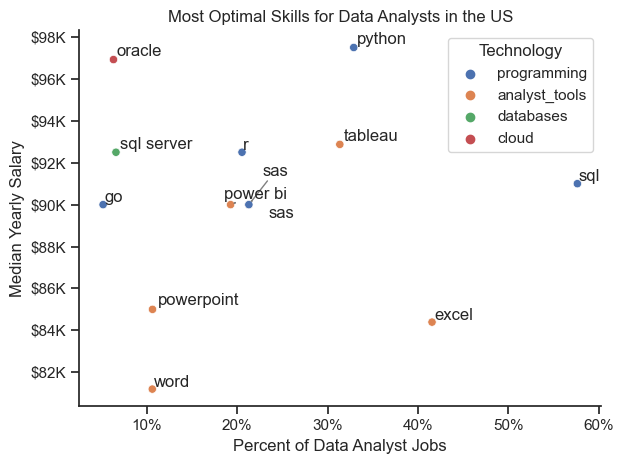

In [46]:
from adjustText import adjust_text

sns.set_theme(style='ticks')

sns.scatterplot(
    data= df_high_demand_tech,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()


# Prepare texts for adjustText
texts = []
for i in range(len(df_high_demand_tech)):
    texts.append(plt.text(
        df_high_demand_tech['skill_percent'].iloc[i], 
        df_high_demand_tech['median_salary'].iloc[i], 
        df_high_demand_tech['skills'].iloc[i]
                            
    ))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))


# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title(f'Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))



# Adjust layout and display plot 
plt.tight_layout()
plt.show()